# watpy for dummies, watpy for all

Watpy helps you to do a couple of things:

 * Basic waveform postprocessing from BAM and THC/cactus simulations
 * Clone, use, and prepare data from the CoRe DB
 
How? Without re-inventing the wheel. Although you are free to use your time as you like, the best approach is probably to learn watpy (it is simple) and help fixing/maintaining it.

**There are several things to test and improve in watpy, please do**

## 0. Start

Clone the repo somewhere and install the package:

```
mkdir somewhere/
cd somehwere/
git clone git@git.tpi.uni-jena.de:core/watpy.git
cd watpy
python setup.py --user
```

Now look at the folders and see some files: they contain python code, functions and classes.

Go to the examples

```
cd watpy/examples
```

and find this tutorial.

The following assumes there is some test data in folders called `MySim_BAM_135135` and `MySim_THC_135135`. 
We will be writing some files, so let's create few more folders:

```
mkdir MySim_BAM_135135/CoReDB # simulation data in CoRe format
mkdir MySim_THC_135135/CoReDB 
mkdir CoRe_DB_clone # CoRe database
```

## 1. Load waveforms from a simulation and compute the strain

In [1]:
from watpy.base.wave import * # wave() and mwave() objects

You probably know all the details of what you have simulated with BAM ... so collect this info:

In [4]:
Msun_sec = 4.925794970773135e-06

bamsim = {}
bamsim['folder'] = 'MySim_BAM_135135' # simulation folder
bamsim['mass'] = 2.700297e+00 # binary mass in solar masses
bamsim['q'] = 1.0 # mass ratio, >= 1
bamsim['Momg22'] = 3.789461e-02 # GW frequency (dim/less, mass rescaled)
bamsim['f0'] = bamsim['Momg22'] / (2*np.pi) / bamsim['mass'] # initial GW frequency in geom. units
bamsim['f0_Hz'] = bamsim['Momg22'] / (2*np.pi) / bamsim['mass']  / Msun_sec # initial GW frequency in Hz
bamsim['massA'] = 1.350149e+00
bamsim['massB'] = 1.350149e+00
bamsim['madm'] = 2.678040e+00 # ADM mass (t=0) 
bamsim['jadm'] = 7.858842e+00 # ADM ang.mom. (t=0) 
bamsim['MbA'] = 1.494607e+00
bamsim['MbB'] = 1.494607e+00
bamsim['level'] = 7
bamsim['levelm'] = 4
bamsim['nxyz'] = 320
bamsim['nmxyz'] = 128
bamsim['dxyz']= 7.520000e+00
bamsim['eos']= 'CSC'
# etc
bamsim['pre-release-folder'] = './MySim_BAM_135135/CoReDB' # folder with CoRe formatted files

#print(mysim['Momg22']) # 0.03789461

Next, we use watpy `wave` and `mwave` classes to compute few things from the $\Psi_4$ output modes. 

### Compute the strain of $(2,2)$ mode with the FFI and write files in CoRe format

In [5]:
w = wave(path = bamsim['folder'], code='bam', filename='Rpsi4mode22_r12.l0', 
         mass = bamsim['mass'], f0 = bamsim['f0'])

This does many things, too many perhaps ... but also computes the strain for you, so it's enough to ask for it: 

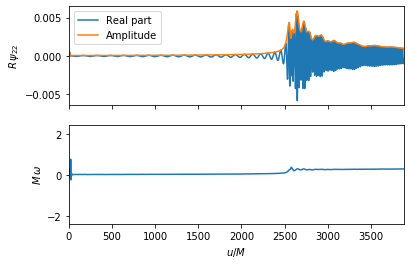

In [6]:
fig = w.show_psi4()

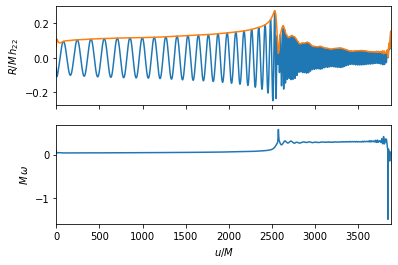

In [7]:
w.get_strain(fcut= bamsim['f0'])
fig = w.show_strain()

Now lets save the data in CoRe format and prepare them for a pre-release (check your folder afterwards)

In [8]:
w.write_to_txt('Psi4', bamsim['pre-release-folder'])
w.write_to_txt('h', bamsim['pre-release-folder'])

### Compute the strain with the FFI for many modes

Make a list of files containing the modes

In [9]:
import glob
fnames = [os.path.split(x)[1] for x in glob.glob('{}/{}'.format(bamsim['folder'],'Rpsi4mode??_r12.l0'))]
print(fnames)

['Rpsi4mode21_r12.l0', 'Rpsi4mode22_r12.l0', 'Rpsi4mode41_r12.l0', 'Rpsi4mode31_r12.l0', 'Rpsi4mode20_r12.l0', 'Rpsi4mode30_r12.l0', 'Rpsi4mode42_r12.l0', 'Rpsi4mode44_r12.l0', 'Rpsi4mode32_r12.l0', 'Rpsi4mode43_r12.l0', 'Rpsi4mode33_r12.l0', 'Rpsi4mode40_r12.l0']


Now we do pretty much the same as above but with the class for multipolar waveforms:

In [11]:
wm = mwaves(path = bamsim['folder'], code = 'bam', filenames = fnames, 
            mass = bamsim['mass'], f0 = bamsim['f0'], ignore_negative_m=True)

We can look again to the $(2,2)$ this way

In [12]:
h22 = wm.get(l=2,m=2)

or also check which modes are there and look at them this way:

In [13]:
print(wm.modes)

[(2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


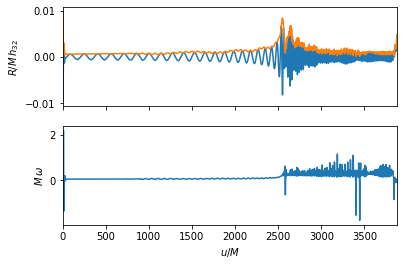

In [14]:
h32 = wm.get(l=3, m=2)
fig = h32.show_strain()

Now we save the modes in CoRe format:

In [15]:
for (l,m) in wm.modes:
        
        psilm = wm.get(var='Psi4',l=l, m=m)
        psilm.write_to_txt('Psi4', bamsim['pre-release-folder'])
        
        hlm = wm.get(l=l, m=m)
        hlm.write_to_txt('h', bamsim['pre-release-folder'])

... and also compute and write the energy curves

In [18]:
wm.energetics(bamsim['massA'], bamsim['massB'], bamsim['madm'], bamsim['jadm'], 
              path_out = bamsim['pre-release-folder'])

Finally, we can create hdf5 data in CoRe format using the `h5` object

In [19]:
from watpy.db_utilities.h5_utils import *

In [20]:
h5u = h5(bamsim['pre-release-folder'],None,None) # write .h5 to mysim['pre-release-folder'] ...

No .h5 file found!


In [21]:
h5u.create(path=bamsim['pre-release-folder']) # ... with all .txt files in mysim['pre-release-folder']

wrote CoRe ./MySim_BAM_135135/CoReDB/data.h5


One can do the same for THC data:

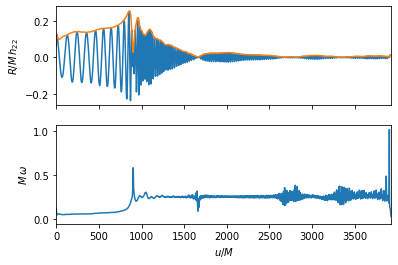

In [22]:
from watpy.base.wave import * 
import glob

Msun_sec = 4.925794970773135e-06

thcsim = {}
thcsim['folder'] = 'MySim_THC_135135' # simulation folder
thcsim['mass'] = 2 * 1.364 # binary mass in solar masses
thcsim['q'] = 1.0 # mass ratio, >= 1
thcsim['f0_Hz'] = 565.08 # initial GW frequency in Hz
thcsim['f0'] = thcsim['f0_Hz'] * Msun_sec
thcsim['Momg22'] = thcsim['mass'] * thcsim['f0'] / (2*np.pi) # initial GW frequency in geom. units
thcsim['massA'] = 1.364
thcsim['massB'] = 1.364
thcsim['madm'] = 2.703 # ADM mass (t=0) 
thcsim['jadm'] = 7.400 # ADM ang.mom. (t=0) 
# etc
thcsim['pre-release-folder'] = 'MySim_THC_135135/CoReDB' # folder with CoRe formatted files

fnames = [os.path.split(x)[1] for x in glob.glob('{}/{}'.format(thcsim['folder'],'mp_Psi4_l?_m?_r400.00.asc'))]

wm = mwaves(path = thcsim['folder'], code = 'cactus', filenames = fnames, 
            mass = thcsim['mass'], f0 = thcsim['f0'], ignore_negative_m=True)

h22 = wm.get(l=2, m=2)
fig = h22.show_strain()

for (l,m) in wm.modes:
    
        psilm = wm.get(var='Psi4',l=l, m=m)
        psilm.write_to_txt('Psi4', thcsim['pre-release-folder'])
        
        hlm = wm.get(l=l, m=m)
        hlm.write_to_txt('h', thcsim['pre-release-folder'])

wm.energetics(thcsim['massA'], thcsim['massB'], thcsim['madm'], thcsim['jadm'], 
              path_out = thcsim['pre-release-folder'])


## 2. Use watpy to clone and work with the CoRe DB

In [2]:
from watpy.db_utilities.index import * # CoRe_index() object

### 2.1 CoRe_index and clone

Initialize a `CoRe_index` object by specifying the path where we would like the CoRe database to be initialized. 
The initialization will either clone the repository `core_database_index` in the given path or syncronize it to (i.e. pull) the latest version in case the repository already exists.

In [3]:
db_path = './CoRe_DB_clone/'
idb = CoRe_index(db_path)

Index found, updating...

git-pull core_database_index ...
 
done!


Form the index we can for example retrieve the list of simulations in the database, e.g.

In [4]:
metadata = idb.nr_dict
print(metadata.keys())
metadata['BAM:0001']

dict_keys(['BAM:0001', 'BAM:0002', 'BAM:0003', 'BAM:0004', 'BAM:0005', 'BAM:0006', 'BAM:0007', 'BAM:0008', 'BAM:0009', 'BAM:0010', 'BAM:0011', 'BAM:0012', 'BAM:0013', 'BAM:0014', 'BAM:0015', 'BAM:0016', 'BAM:0017', 'BAM:0018', 'BAM:0019', 'BAM:0020', 'BAM:0021', 'BAM:0022', 'BAM:0023', 'BAM:0024', 'BAM:0025', 'BAM:0026', 'BAM:0027', 'BAM:0028', 'BAM:0029', 'BAM:0030', 'BAM:0031', 'BAM:0032', 'BAM:0033', 'BAM:0034', 'BAM:0035', 'BAM:0036', 'BAM:0037', 'BAM:0038', 'BAM:0039', 'BAM:0040', 'BAM:0041', 'BAM:0042', 'BAM:0043', 'BAM:0044', 'BAM:0045', 'BAM:0046', 'BAM:0047', 'BAM:0048', 'BAM:0049', 'BAM:0050', 'BAM:0051', 'BAM:0052', 'BAM:0053', 'BAM:0054', 'BAM:0055', 'BAM:0056', 'BAM:0057', 'BAM:0058', 'BAM:0059', 'BAM:0060', 'BAM:0061', 'BAM:0062', 'BAM:0063', 'BAM:0064', 'BAM:0065', 'BAM:0066', 'BAM:0067', 'BAM:0068', 'BAM:0069', 'BAM:0070', 'BAM:0071', 'BAM:0072', 'BAM:0073', 'BAM:0074', 'BAM:0075', 'BAM:0076', 'BAM:0077', 'BAM:0078', 'BAM:0079', 'BAM:0080', 'BAM:0081', 'BAM:0082', 'BAM:

{'database_key': 'BAM:0001',
 'id_mass_starA': '1.350',
 'id_mass_starB': '1.350',
 'id_spin_starA': '0.00, 0.00, 0.00',
 'id_spin_starB': '0.00, 0.00, 0.00',
 'id_dimless_spin_starA': '0.00 ,0.00 ,0.00 ',
 'id_dimless_spin_starB': '0.00 ,0.00 ,0.00 ',
 'id_gw_frequency_Momega22': '0.038',
 'grid_spacing_min': '0.093',
 'id_eos': '2B',
 'available_resolutions': 'R01, R02, R03, R04'}

**Note that the index contains only a subset of all the available metadata for each model.**

We can find a group of simulations based on some of these keys:

In [5]:
dd2 = idb.find('id_eos', 'DD2')
# here dd2 is a python dictionary, whose keys are the database keys of the simulations
print(dd2)

{'THC:0010': {'database_key': 'THC:0010', 'id_mass_starA': '1.200', 'id_mass_starB': '1.200', 'id_spin_starA': '0.00, 0.00, 0.00', 'id_spin_starB': '0.00, 0.00, 0.00', 'id_dimless_spin_starA': '0.00 ,0.00 ,0.00 ', 'id_dimless_spin_starB': '0.00 ,0.00 ,0.00 ', 'id_gw_frequency_Momega22': '0.047', 'grid_spacing_min': '0.125', 'id_eos': 'DD2', 'available_resolutions': 'R01'}, 'THC:0011': {'database_key': 'THC:0011', 'id_mass_starA': '1.250', 'id_mass_starB': '1.250', 'id_spin_starA': '0.00, 0.00, 0.00', 'id_spin_starB': '0.00, 0.00, 0.00', 'id_dimless_spin_starA': '0.00 ,0.00 ,0.00 ', 'id_dimless_spin_starB': '0.00 ,0.00 ,0.00 ', 'id_gw_frequency_Momega22': '0.050', 'grid_spacing_min': '0.125', 'id_eos': 'DD2', 'available_resolutions': 'R01'}, 'THC:0012': {'database_key': 'THC:0012', 'id_mass_starA': '1.300', 'id_mass_starB': '1.300', 'id_spin_starA': '0.00, 0.00, 0.00', 'id_spin_starB': '0.00, 0.00, 0.00', 'id_dimless_spin_starA': '0.00 ,0.00 ,0.00 ', 'id_dimless_spin_starB': '0.00 ,0.00

It is also possible to plot some quantities

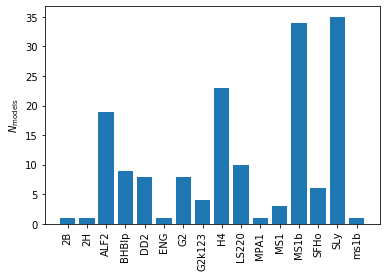

In [6]:
idb.show('id_eos')

We use the index as follows to clone the entire database:

In [7]:
#idb.sync_database(lfs=True, verbose=False)

But if only a subset of simulations are required, we can clone only the relative repositories. We can enforce the syncronization of a subset of simulations by passing explicitly the `sync_database` to the `db_list` argument:

In [8]:
idb.sync_database(db_list=dd2.keys(), verbose=False, lfs=True, prot='https')

git-pull THC_0010 ...
done!
git-pull THC_0011 ...
done!
git-pull THC_0012 ...
done!
git-pull THC_0013 ...
done!
git-pull THC_0014 ...
done!
git-pull THC_0015 ...
done!
git-pull THC_0016 ...
done!
git-pull THC_0017 ...
done!


### 2.2 Work with CoRe DB data: CoRe_database, CoRe_simulation, CoRe_run

In [1]:
from watpy.db_utilities.dbutils import * # CoRe_database() CoRe_simulation() and CoRe_run() objects
from watpy.db_utilities.index import *

In [2]:
db_path = './CoRe_DB_clone/'
idb = CoRe_index(db_path)

Index found, updating...

git-pull core_database_index ...
 
done!


First, one should get the metadata for all available simulations in the cloned repo by initializing a `CoRe_database` object:

In [11]:
cdb = CoRe_database(db_path)

# now you can work with these dictionaries
print(cdb.sim_list[0],len(cdb.sim_list))

sims = cdb.sims
sims.keys()

{'database_key': 'THC:0013', 'available_resolutions': 'R01, R02', 'simulation_name': 'DD2_1.350_1.350_0.00_0.00_0.055', 'reference_bibkeys': 'Radice:2016rys Radice:2017lry', 'id_code': 'LORENE', 'id_type': 'Irrotational', 'id_mass': '2.7', 'id_rest_mass': '2.94554', 'id_mass_ratio': '1.0', 'id_ADM_mass': '2.67288', 'id_ADM_angularmomentum': '7.01514', 'id_gw_frequency_Hz': '663.58', 'id_gw_frequency_Momega22': '0.0554514940011', 'id_eos': 'DD2', 'id_kappa2T': '159.0084296249798', 'id_Lambda': '848.0449579998918', 'id_eccentricity': '', 'id_mass_starA': '1.35', 'id_rest_mass_starA': '1.47277', 'id_spin_starA': '0, 0, 0', 'id_LoveNum_kell_starA': '0.09996, 0.0269, 0.00984', 'id_Lambdaell_starA': '848.0449579998921, 2001.0063178210328, 4584.234164607441', 'id_mass_starB': '1.35', 'id_rest_mass_starB': '1.47277', 'id_spin_starB': '0, 0, 0', 'id_LoveNum_kell_starB': '0.09996, 0.0269, 0.00984', 'id_Lambdaell_starB': '848.0449579998921, 2001.0063178210328, 4584.234164607441'} 8


dict_keys(['THC:0013', 'THC:0014', 'THC:0012', 'THC:0010', 'THC:0011', 'THC:0016', 'THC:0015', 'THC:0017'])

`sims` is a python dictionary where the keys are the simulations' *database_keys* and the values are `Core_Simulation` objects. The `CoRe_simulation` object contains all information on the number of runs available for that set of initial data, as well as the required routines to extract the data from the HDF5 archive into readable text files that can be easily loaded into. The `CoRe_simulation` object essentially contains the same information present in one of the repo of the CoRe DB group.

As for the index, the parameters distributions can be visualized by keys:

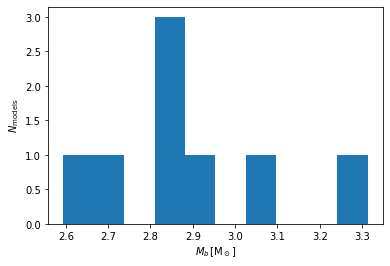

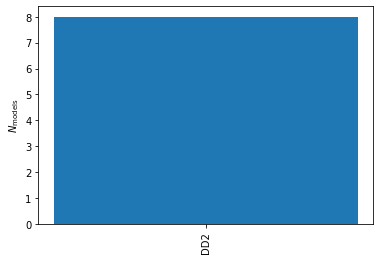

In [12]:
cdb.show('id_rest_mass')
cdb.show('id_eos')

Now, lets pick one simulation and see what is inside:

In [13]:
thc13 = sims['THC:0013']

print(thc13.__dict__)
print(thc13.runs_id)

{'path': './CoRe_DB_clone/THC_0013', 'runs': {'R01': <watpy.db_utilities.dbutils.CoRe_run object at 0x7efdd391b890>, 'R02': <watpy.db_utilities.dbutils.CoRe_run object at 0x7efdd3821890>}, 'mdata': {'database_key': 'THC:0013', 'available_resolutions': 'R01, R02', 'simulation_name': 'DD2_1.350_1.350_0.00_0.00_0.055', 'reference_bibkeys': 'Radice:2016rys Radice:2017lry', 'id_code': 'LORENE', 'id_type': 'Irrotational', 'id_mass': '2.7', 'id_rest_mass': '2.94554', 'id_mass_ratio': '1.0', 'id_ADM_mass': '2.67288', 'id_ADM_angularmomentum': '7.01514', 'id_gw_frequency_Hz': '663.58', 'id_gw_frequency_Momega22': '0.0554514940011', 'id_eos': 'DD2', 'id_kappa2T': '159.0084296249798', 'id_Lambda': '848.0449579998918', 'id_eccentricity': '', 'id_mass_starA': '1.35', 'id_rest_mass_starA': '1.47277', 'id_spin_starA': '0, 0, 0', 'id_LoveNum_kell_starA': '0.09996, 0.0269, 0.00984', 'id_Lambdaell_starA': '848.0449579998921, 2001.0063178210328, 4584.234164607441', 'id_mass_starB': '1.35', 'id_rest_mass_

The information on each run of the simulation is stored in a `CoRe_run` object. We can now extract data via the *h5* sub-class and dump them into `.txt` files. We can choose what to extract ($h$, $\Psi_4$ or the energetics of the waveform) or just extract everything in the same directory where the original HDF5 archive was stored. The `.txt` files can notw be loaded with any python routine or again with the wave classes of watpy.

In [14]:
r01 = thc13.runs['R01']

for f in r01.dfile: print(f)

# write .txt files
r01.h5.extract_h() 
r01.h5.extract_p4()
r01.h5.extract_ej()

# or in one:
#r01.h5.extract_all()

energy
rh_22
rpsi4_22


**NOTE: The extracted files are not meant to be tracked by the CoRe DB repo and should not be added to any commit.**
The `CoRe_run` object can help you to delete the `.txt` files as follows:

In [5]:
#r01.clean_txt() # delete files extracted from h5

The `CoRe_run` object has also routines to directly read the data at the chosen extraction radius. If no radius is given, or if the selected radius is not within the available ones, the farthest radius from the center of the simulation domain is chosen by default. So, one can finally do:

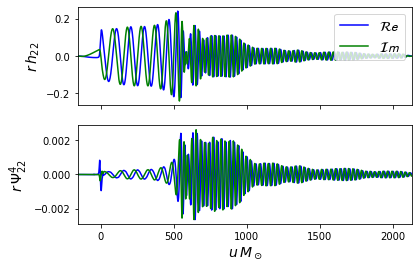

In [53]:
u, h = r01.h5.read('rh_22')
r01.h5.show('both')

## 3. Use watpy to add a simulation to the CoRe DB

Let's assume you have all data of a new simulation in the CoRe format in some folder, e.g. in `MySim_BAM_135135/CoReDB`, and want to update this particular run to the CoRe DB. How to procede? We start as above, initializing a `CoRe_index` and a `CoRe_database` object. **NOTE: Here it seems necessary to clone the full CoRe DB to have the complete sim list. However, it should be possible to do the same working only with the DB index (FIXME).**

In [3]:
from watpy.db_utilities.dbutils import * # CoRe_database() CoRe_simulation() and CoRe_run() objects
from watpy.db_utilities.index import *

In [4]:
db_path = './CoRe_DB_clone/'
idb = CoRe_index(db_path)
idb.sync_database(lfs=True, verbose=False)
cdb = CoRe_database(db_path)

Index found, updating...

git-pull core_database_index ...
 
done!
git-clone BAM_0001 ...
done!
git-clone BAM_0002 ...
done!
git-clone BAM_0003 ...
done!
git-clone BAM_0004 ...
done!
git-clone BAM_0005 ...
done!
git-clone BAM_0006 ...
done!
git-clone BAM_0007 ...
done!
git-clone BAM_0008 ...
done!
git-clone BAM_0009 ...
done!
git-clone BAM_0010 ...
done!
git-clone BAM_0011 ...
done!
git-clone BAM_0012 ...
done!
git-clone BAM_0013 ...
done!
git-clone BAM_0014 ...
done!
git-clone BAM_0015 ...
done!
git-clone BAM_0016 ...
done!
git-clone BAM_0017 ...
done!
git-clone BAM_0018 ...
done!
git-clone BAM_0019 ...
done!
git-clone BAM_0020 ...
done!
git-clone BAM_0021 ...
done!
git-clone BAM_0022 ...
done!
git-clone BAM_0023 ...
done!
git-clone BAM_0024 ...
done!
git-clone BAM_0025 ...
done!
git-clone BAM_0026 ...
done!
git-clone BAM_0027 ...
done!
git-clone BAM_0028 ...
done!
git-clone BAM_0029 ...
done!
git-clone BAM_0030 ...
done!
git-clone BAM_0031 ...
done!
git-clone BAM_0032 ...
done!
git-c

Now we add a new run in the DB. The first thing to do is to decide a simulation name. This is typically a string that identifies the physical properties of the simulated binary. So far, we have been using names like `MS1b_1.350_1.350_0.00_0.00_0.038_0.291_bigbox` (see `BAM:0065:R08`) and they can be generated with the function below. This naming convention can be i principle changed when adding a new simulation. However, it is important to keep the same convention to add a new run to an existing simulation because the DB key will be assigned based on the simulation name: if this exists, a run is added to an existing simulation (repo), else a new key and simulation (and repo are created). **NOTE: the `meatadata_main.txt` at the simulation level contains a field `simulation_name` which has a different value of the same field in the `metadata.txt` at the run level. The value of the former value is the sub-string (initial part) of the latter that is common to all the runs**

In [44]:
def generate_simulation_name(EOS,MA,MB,SzA,SzB,Momega0,extra=None):
    """ String for simulation name as appearing in the metadata_main.txt """
    name = '{}_{:.3f}_{:.3f}_{:.2f}_{:.2f}_{:.3f}'.format(EOS,MA,MB,SzA,SzB,Momega0)
    if extra is not None:
        name += extra
    return name

In [45]:
simname_new_run = generate_simulation_name('SCS',1.35,1.35,0,0,0.03789461,"_0.058_gridX") # add resolution and other specs
print(simname_new_run)

SCS_1.350_1.350_0.00_0.00_0.038_0.058_gridX


7/4

In [32]:
7.5/2**7.

0.05859375

In [39]:
new_dbkey = cdb.setup_new_run(simname_new_run, 'BAM')

127
Run exists!


In [23]:
print('Tot sim {}'.format(len(cdb.sims)))
bam_sims = [x for x in cdb.sims.keys() if 'BAM:' in x]
print('BAM sims {}'.format(len(bam_sims)))
cdb.sims.keys()

Tot sim 163
BAM sims 127


dict_keys(['BAM:0007', 'THC:0027', 'BAM:0003', 'BAM:0055', 'BAM:0108', 'THC:0018', 'BAM:0095', 'THC:0008', 'BAM:0054', 'THC:0004', 'THC:0036', 'BAM:0045', 'THC:0020', 'BAM:0082', 'BAM:0124', 'BAM:0117', 'THC:0013', 'BAM:0050', 'THC:0025', 'BAM:0102', 'BAM:0061', 'BAM:0113', 'BAM:0064', 'BAM:0009', 'BAM:0121', 'BAM:0030', 'BAM:0058', 'BAM:0119', 'THC:0014', 'BAM:0035', 'BAM:0034', 'THC:0003', 'BAM:0044', 'BAM:0056', 'BAM:0125', 'BAM:0069', 'BAM:0120', 'BAM:0070', 'THC:0029', 'BAM:0104', 'BAM:0080', 'BAM:0049', 'BAM:0015', 'BAM:0107', 'BAM:0090', 'THC:0019', 'THC:0023', 'BAM:0093', 'BAM:0103', 'BAM:0110', 'BAM:0078', 'THC:0007', 'THC:0030', 'BAM:0126', 'BAM:0041', 'BAM:0106', 'BAM:0112', 'BAM:0039', 'BAM:0008', 'BAM:0047', 'BAM:0074', 'BAM:0046', 'BAM:0092', 'BAM:0091', 'BAM:0066', 'BAM:0098', 'BAM:0063', 'THC:0009', 'THC:0001', 'BAM:0101', 'THC:0002', 'BAM:0038', 'BAM:0072', 'BAM:0031', 'THC:0012', 'BAM:0053', 'BAM:0105', 'THC:0010', 'BAM:0068', 'BAM:0059', 'BAM:0021', 'BAM:0076', 'BAM: